In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.sql.functions import col
from pyspark.sql.types import DoubleType

In [3]:
path = "student_lifestyle_dataset.csv"

In [4]:
spark = SparkSession.builder.appName("A5").getOrCreate()
df = spark.read.csv(path, header=True, inferSchema=True)
# Columns Available:
#    Student_ID
#    Study_Hours_Per_Day
#    Extracurricular_Hours_Per_Day
#    Sleep_Hours_Per_Day
#    Social_Hours_Per_Day
#    Physical_Activity_Hours_Per_Day
#    Stress_Level
#    Gender
#    Grades
df.select("Student_ID", "Study_Hours_Per_Day", "Extracurricular_Hours_Per_Day", "Sleep_Hours_Per_Day", "Grades").show(5)

# Total number of entries:
print(f"""There are {df.count()} rows and {len(df.columns)} columns in this dataset.""")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/10 15:42:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+----------+-------------------+-----------------------------+-------------------+------+
|Student_ID|Study_Hours_Per_Day|Extracurricular_Hours_Per_Day|Sleep_Hours_Per_Day|Grades|
+----------+-------------------+-----------------------------+-------------------+------+
|         1|                6.9|                          3.8|                8.7|  7.48|
|         2|                5.3|                          3.5|                8.0|  6.88|
|         3|                5.1|                          3.9|                9.2|  6.68|
|         4|                6.5|                          2.1|                7.2|   7.2|
|         5|                8.1|                          0.6|                6.5|  8.78|
+----------+-------------------+-----------------------------+-------------------+------+
only showing top 5 rows

There are 2000 rows and 9 columns in this dataset.


In [ ]:
# Extract "nontrivial" information from the dataset.
# What can you say from the data?
# Any interesting data trends that cannot be easily guessed or can be used to justify some hypothesis?

# The trifecta: people say that in college, you can only have 2/3 of these: sleep, socialization, and study time/good grades.
#   Based on the data, is this true?
#   What features have the greatest impact on grades?

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as func

In [12]:
# Establish Sleep, Social, and Academics Scores
# Sleep = Since there's only 1 sleep metric, that will determine sleep score.
# Social = Mean of extracurricular, social, and physical activity hours per day.
# Academics = Mean of study hours per day and grades.
# Scores are rounded to a max of 3 decimal places
df_scores = df.withColumns({'Sleep_Score': df.Sleep_Hours_Per_Day, 
                            'Social_Score': func.round(((df.Extracurricular_Hours_Per_Day + df.Social_Hours_Per_Day + df.Physical_Activity_Hours_Per_Day)/3), 3),
                            'Academics_Score': func.round(((df.Study_Hours_Per_Day + df.Grades)/2), 3)})

df_scores.select('Student_ID', 'Sleep_Score', 'Social_Score', 'Academics_Score').show(10)

+----------+-----------+------------+---------------+
|Student_ID|Sleep_Score|Social_Score|Academics_Score|
+----------+-----------+------------+---------------+
|         1|        8.7|         2.8|           7.19|
|         2|        8.0|       3.567|           6.09|
|         3|        9.2|       3.233|           5.89|
|         4|        7.2|       3.433|           6.85|
|         5|        6.5|       3.133|           8.44|
|         6|        8.0|       3.333|           6.56|
|         7|        5.3|       3.567|           7.85|
|         8|        5.6|       3.333|            8.2|
|         9|        6.3|       4.167|          6.125|
|        10|        9.8|       2.167|            7.3|
+----------+-----------+------------+---------------+
only showing top 10 rows



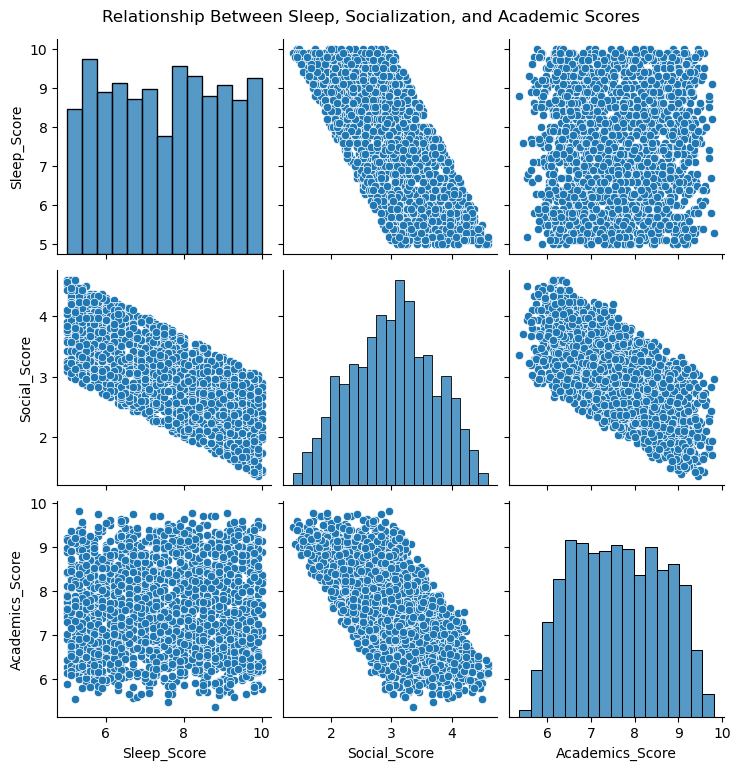

In [22]:
# Visualize the data
p_df_scores = df_scores.toPandas()
sns.pairplot(p_df_scores, vars=['Sleep_Score', 'Social_Score', 'Academics_Score'])
plt.suptitle("Relationship Between Sleep, Socialization, and Academic Scores", y=1.02)
plt.show()

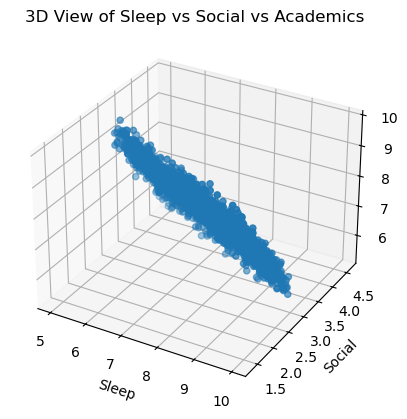

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(p_df_scores['Sleep_Score'], p_df_scores['Social_Score'], p_df_scores['Academics_Score'])

ax.set_xlabel('Sleep')
ax.set_ylabel('Social')
ax.set_zlabel('Academics')
plt.title("3D View of Sleep vs Social vs Academics")
plt.show()

In [ ]:
# Visualize the data (at least TWO types of nontrivial plots)
# Consider: Violin/Box Plots, Histogram, Density Plot, Correlation Matrix, Hexagonal Binning